In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [8]:
configFileName = "config-multiplexing.yml"
with open(configFileName, "r") as stream:
    try:
        yamlConfig = yaml.safe_load(stream)
    except yaml.YAMLError as err:
        print(err)

# Read in the geometry
try:
    systemGeom = np.asarray(yamlConfig["detector geometry"])
    sensGeomIds = np.asarray(yamlConfig["detector"]["sensitive geometry indices"])
    detSubs = np.asarray(yamlConfig["detector"]["crystal n subdivision xyz"])
    # Calculate Image space N subdivision and size.
    imageDims = np.asarray(yamlConfig["image"]["dimension xyz"])
    imageVxpms = np.asarray(yamlConfig["image"]["voxel per mm xyz"])
    imageSubs = np.asarray(yamlConfig["image"]["subdivision xyz"])
    angle_rad = yamlConfig["image"]["detector rotation"]
    x_shift = yamlConfig["image"]["detector x-shift"]
except yaml.YAMLError as err:
    print("Error reading the configurations!", err)
    exit(1)

passiveCuboids = np.concatenate(
    (
        systemGeom[np.where(systemGeom[:, 6] == 0)],
        systemGeom[np.where(systemGeom[:, 6] == 1)],
    ),
    axis=0,
)

sensitiveCuboids = systemGeom[np.where(systemGeom[:, 6] == 3)]


yMin = np.amin(systemGeom[:, 2])
yMax = np.amax(systemGeom[:, 3])
xMin = np.amin(systemGeom[:, 0])
xMax = np.amax(systemGeom[:, 1]) 
detectorDim_x = xMax - xMin
detectorDim_y = yMax - yMin
trans_x = imageDims[0] * 0.5
trans_y = imageDims[1] * 0.5
y_shift = 0.5 * detectorDim_y
imageNxyz = imageDims * imageVxpms
mmPerVoxel = 1.0 / imageVxpms


with np.load(yamlConfig["out npz filename"]) as data:
    sysmat = data["sysmat"]
    print(sysmat.shape)

# with np.load("test.npz") as data:
#     sysmat = data["sysmat"]
#     print(sysmat.shape)
imageNxyz = imageDims * imageVxpms
nSensDets = sensitiveCuboids.shape[0]
# print(imageNxyz,nSensDets)
matxymap = sysmat.reshape(int(imageNxyz[0]), int(imageNxyz[1]), nSensDets).T

print(
    "x_shift + trans_x: ",
    x_shift + trans_x,
    "\ntrans_y - y_shift: ",
    -y_shift + trans_y,
)


(10000,)
x_shift + trans_x:  55.0 
trans_y - y_shift:  12.5


In [7]:
np.min(matxymap)

0.0

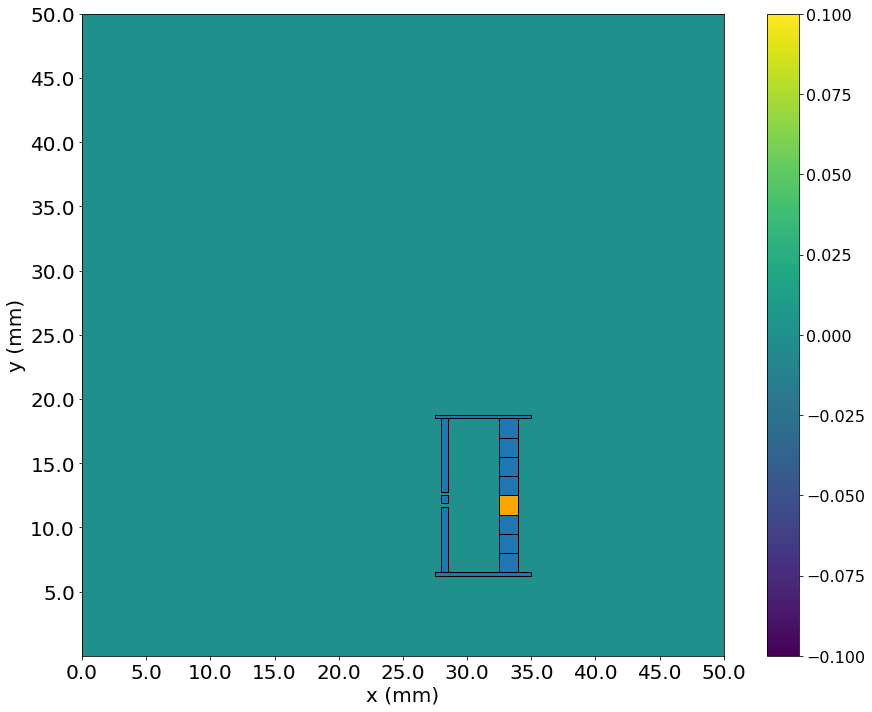

In [9]:
detectors = np.array(yamlConfig["detector geometry"])

det_xy = np.array(
    [detectors[:, 0] + x_shift + trans_x, detectors[:, 2] - y_shift + trans_y]
).T
det_inc_xy = np.array(
    [(detectors[:, 1] - detectors[:, 0]), (detectors[:, 3] - detectors[:, 2])]
).T

targets = sensitiveCuboids

targets_xy = np.array(
    [targets[:, 0] + x_shift + trans_x, targets[:, 2] - y_shift + trans_y]
).T
targets_inc_xy = np.array(
    [targets[:, 1] - targets[:, 0], targets[:, 3] - targets[:, 2]]
).T

target_rect_list = [
    Rectangle(xy, inc_xy[0], inc_xy[1])
    for xy, inc_xy in zip(targets_xy, targets_inc_xy)
]
rect_list = [
    Rectangle(xy, inc_xy[0], inc_xy[1]) for xy, inc_xy in zip(det_xy, det_inc_xy)
]
pc = PatchCollection(rect_list, ec="black")



fig, ax = plt.subplots(figsize=(16, 10))
im_extent = (0, imageNxyz[0], 0, imageNxyz[1])
imshow = ax.imshow(matxymap[0], origin="lower", extent=im_extent, aspect="equal")
ax.add_collection(pc)
targets_pc = PatchCollection(target_rect_list, ec="black", fc="orange")
ax.add_collection(targets_pc)
ax.set_xlim(0, 0.5 * imageNxyz[0] + x_shift + detectorDim_x + 1)
ax.set_ylim(0, imageNxyz[1])

ax.set_xticks(np.arange(0, imageNxyz[0] + 1, 10))
ax.set_xticklabels(np.arange(0, imageNxyz[0] + 1, 10) * mmPerVoxel[0], size=20)
ax.set_yticks(np.arange(0, imageNxyz[1] + 1, 10)[1:])
ax.set_yticklabels((np.arange(0, imageNxyz[1] + 1, 10) * mmPerVoxel[1])[1:], size=20)
ax.set_xlabel("x (mm)", size=20)
ax.set_ylabel("y (mm)", size=20)

cbar = plt.colorbar(imshow, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)
plt.tight_layout()